In [1]:
# Libraries

import itertools
import numpy
import os
import pandas
import platform
import pickle
import shutil
import sklearn
import sys

In [2]:
# Classes

from sklearn.preprocessing import LabelBinarizer
from pandas                import DataFrame

In [3]:
# Root directory

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux' :
			ROOT = '/d/hpc/home/up4472/workspace/upolanc-thesis'
		elif platform.system() == 'Windows' :
			ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else :
			raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [4]:
# Code

from source.python.data.feature import annodata as data_anndata
from source.python.data.feature import target   as data_target
from source.python.io           import loader   as data_loader
from source.python.io           import writer   as data_writer

# 1. Setup

In [5]:
# Setup some directory paths

CWD = ROOT
OUT = os.path.join(CWD, 'output')
RES = os.path.join(CWD, 'resources')

OUT_DATA   = os.path.join(OUT,      'nbp05-target')
OUT_PLOT   = os.path.join(OUT_DATA, 'plot')
RES_NBP04  = os.path.join(OUT,      'nbp04-feature')

shutil.rmtree(OUT_DATA, ignore_errors = True)

os.makedirs(OUT_DATA, exist_ok = True)
os.makedirs(OUT_PLOT, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT_DATA}')
print(f'   Output Directory : {OUT_PLOT}')
print(f' Resource Directory : {RES_NBP04}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp05-target
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp05-target\plot
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp04-feature


In [6]:
# Load the annotated and cleaned data

anndata = data_loader.load_h5ad(
	filename = os.path.join(RES_NBP04, 'arabidopsis-r36.h5ad')
)

feature_frequency = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-frequency.npz')
)

feature_stability = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-stability.npz')
)

# 2. Regression

In [7]:
# Extract the transcript tpm values

values, order = data_target.extract_tpm_multi(
	data      = anndata,
	layer     = 'boxcox1p',
	groups    = ['Tissue', 'Age', 'Group', 'Perturbation'],
	functions = [
		('max',  lambda x : numpy.max(x, axis = 0)),
		('mean', lambda x : numpy.mean(x, axis = 0)),
		('std',  lambda x : numpy.std(x, axis = 0))
	]
)

In [8]:
# Display an example of the transcript tpm values

gene = anndata.var.index.to_list()[0]

for index, (key, value) in enumerate(values[gene].items()) :
	print(f'{key:17s} : [{len(value):2d}] ' + ' '.join('{:5.3f}'.format(x) for x in value))

tissue-max        : [ 5] 2.302 2.858 2.989 2.711 2.908
tissue-mean       : [ 5] 1.568 1.301 2.219 1.464 1.716
tissue-std        : [ 5] 0.262 0.516 0.411 0.409 0.419
age-max           : [ 4] 2.881 2.858 1.880 2.989
age-mean          : [ 4] 1.521 1.697 1.400 1.921
age-std           : [ 4] 0.551 0.469 0.237 0.455
group-max         : [14] 2.302 2.790 2.873 1.880 2.881 1.671 2.858 2.279 1.808 1.790 2.064 2.989 2.711 2.908
group-mean        : [14] 1.593 1.261 2.249 1.335 1.676 1.463 1.793 1.729 1.328 1.749 1.653 2.228 1.968 1.792
group-std         : [14] 0.287 0.501 0.428 0.279 0.403 0.103 0.482 0.465 0.335 0.041 0.182 0.360 0.442 0.432
perturbation-max  : [ 7] 2.989 2.860 2.587 2.881 2.646 2.660 2.728
perturbation-mean : [ 7] 1.921 1.574 2.043 1.631 1.410 1.394 1.574
perturbation-std  : [ 7] 0.459 0.543 0.259 0.498 0.552 0.595 0.544


## 2.1 Distributions

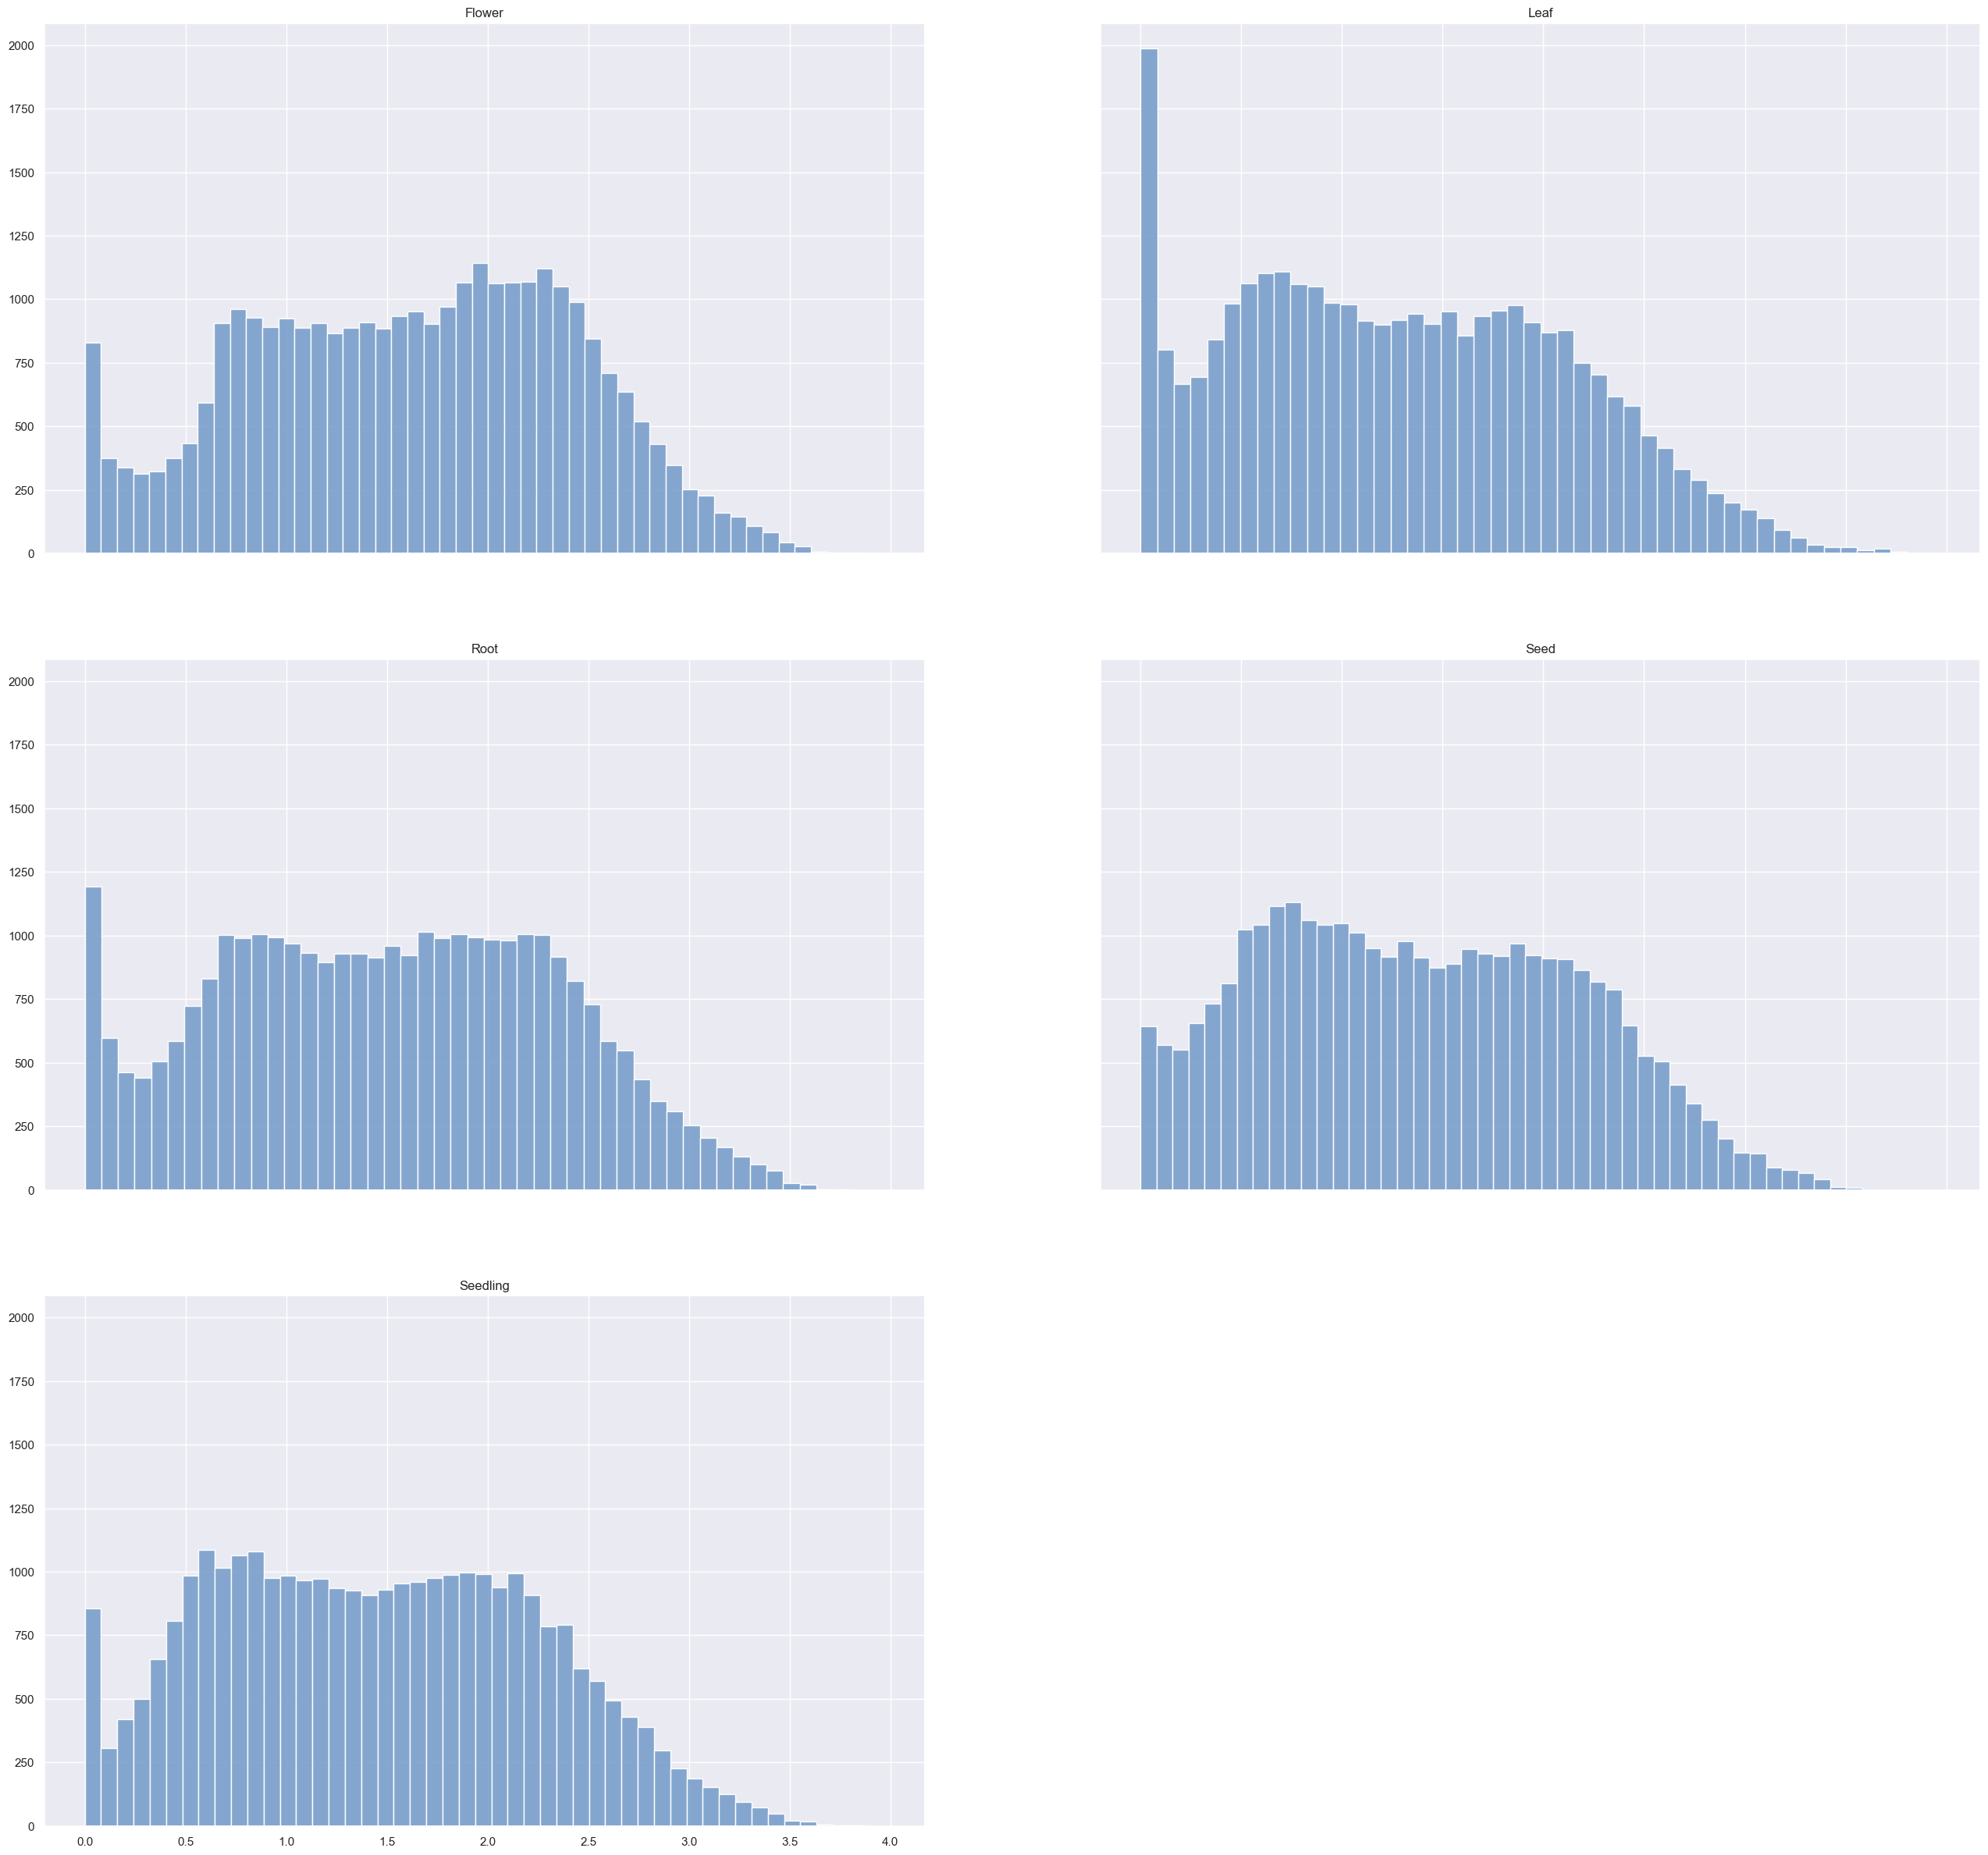

In [9]:
# Compute the regression distribution and display per tissue

distribution = data_target.distribution_group(
	data   = values,
	order  = order,
	select = 'mean',
	genes  = anndata.var.index.to_list()
)

data_target.distribution_histplot(
	data     = distribution,
	groupby  = 'tissue',
	discrete = False,
	filename = os.path.join(OUT_PLOT, 'distribution-tissue-mean')
)

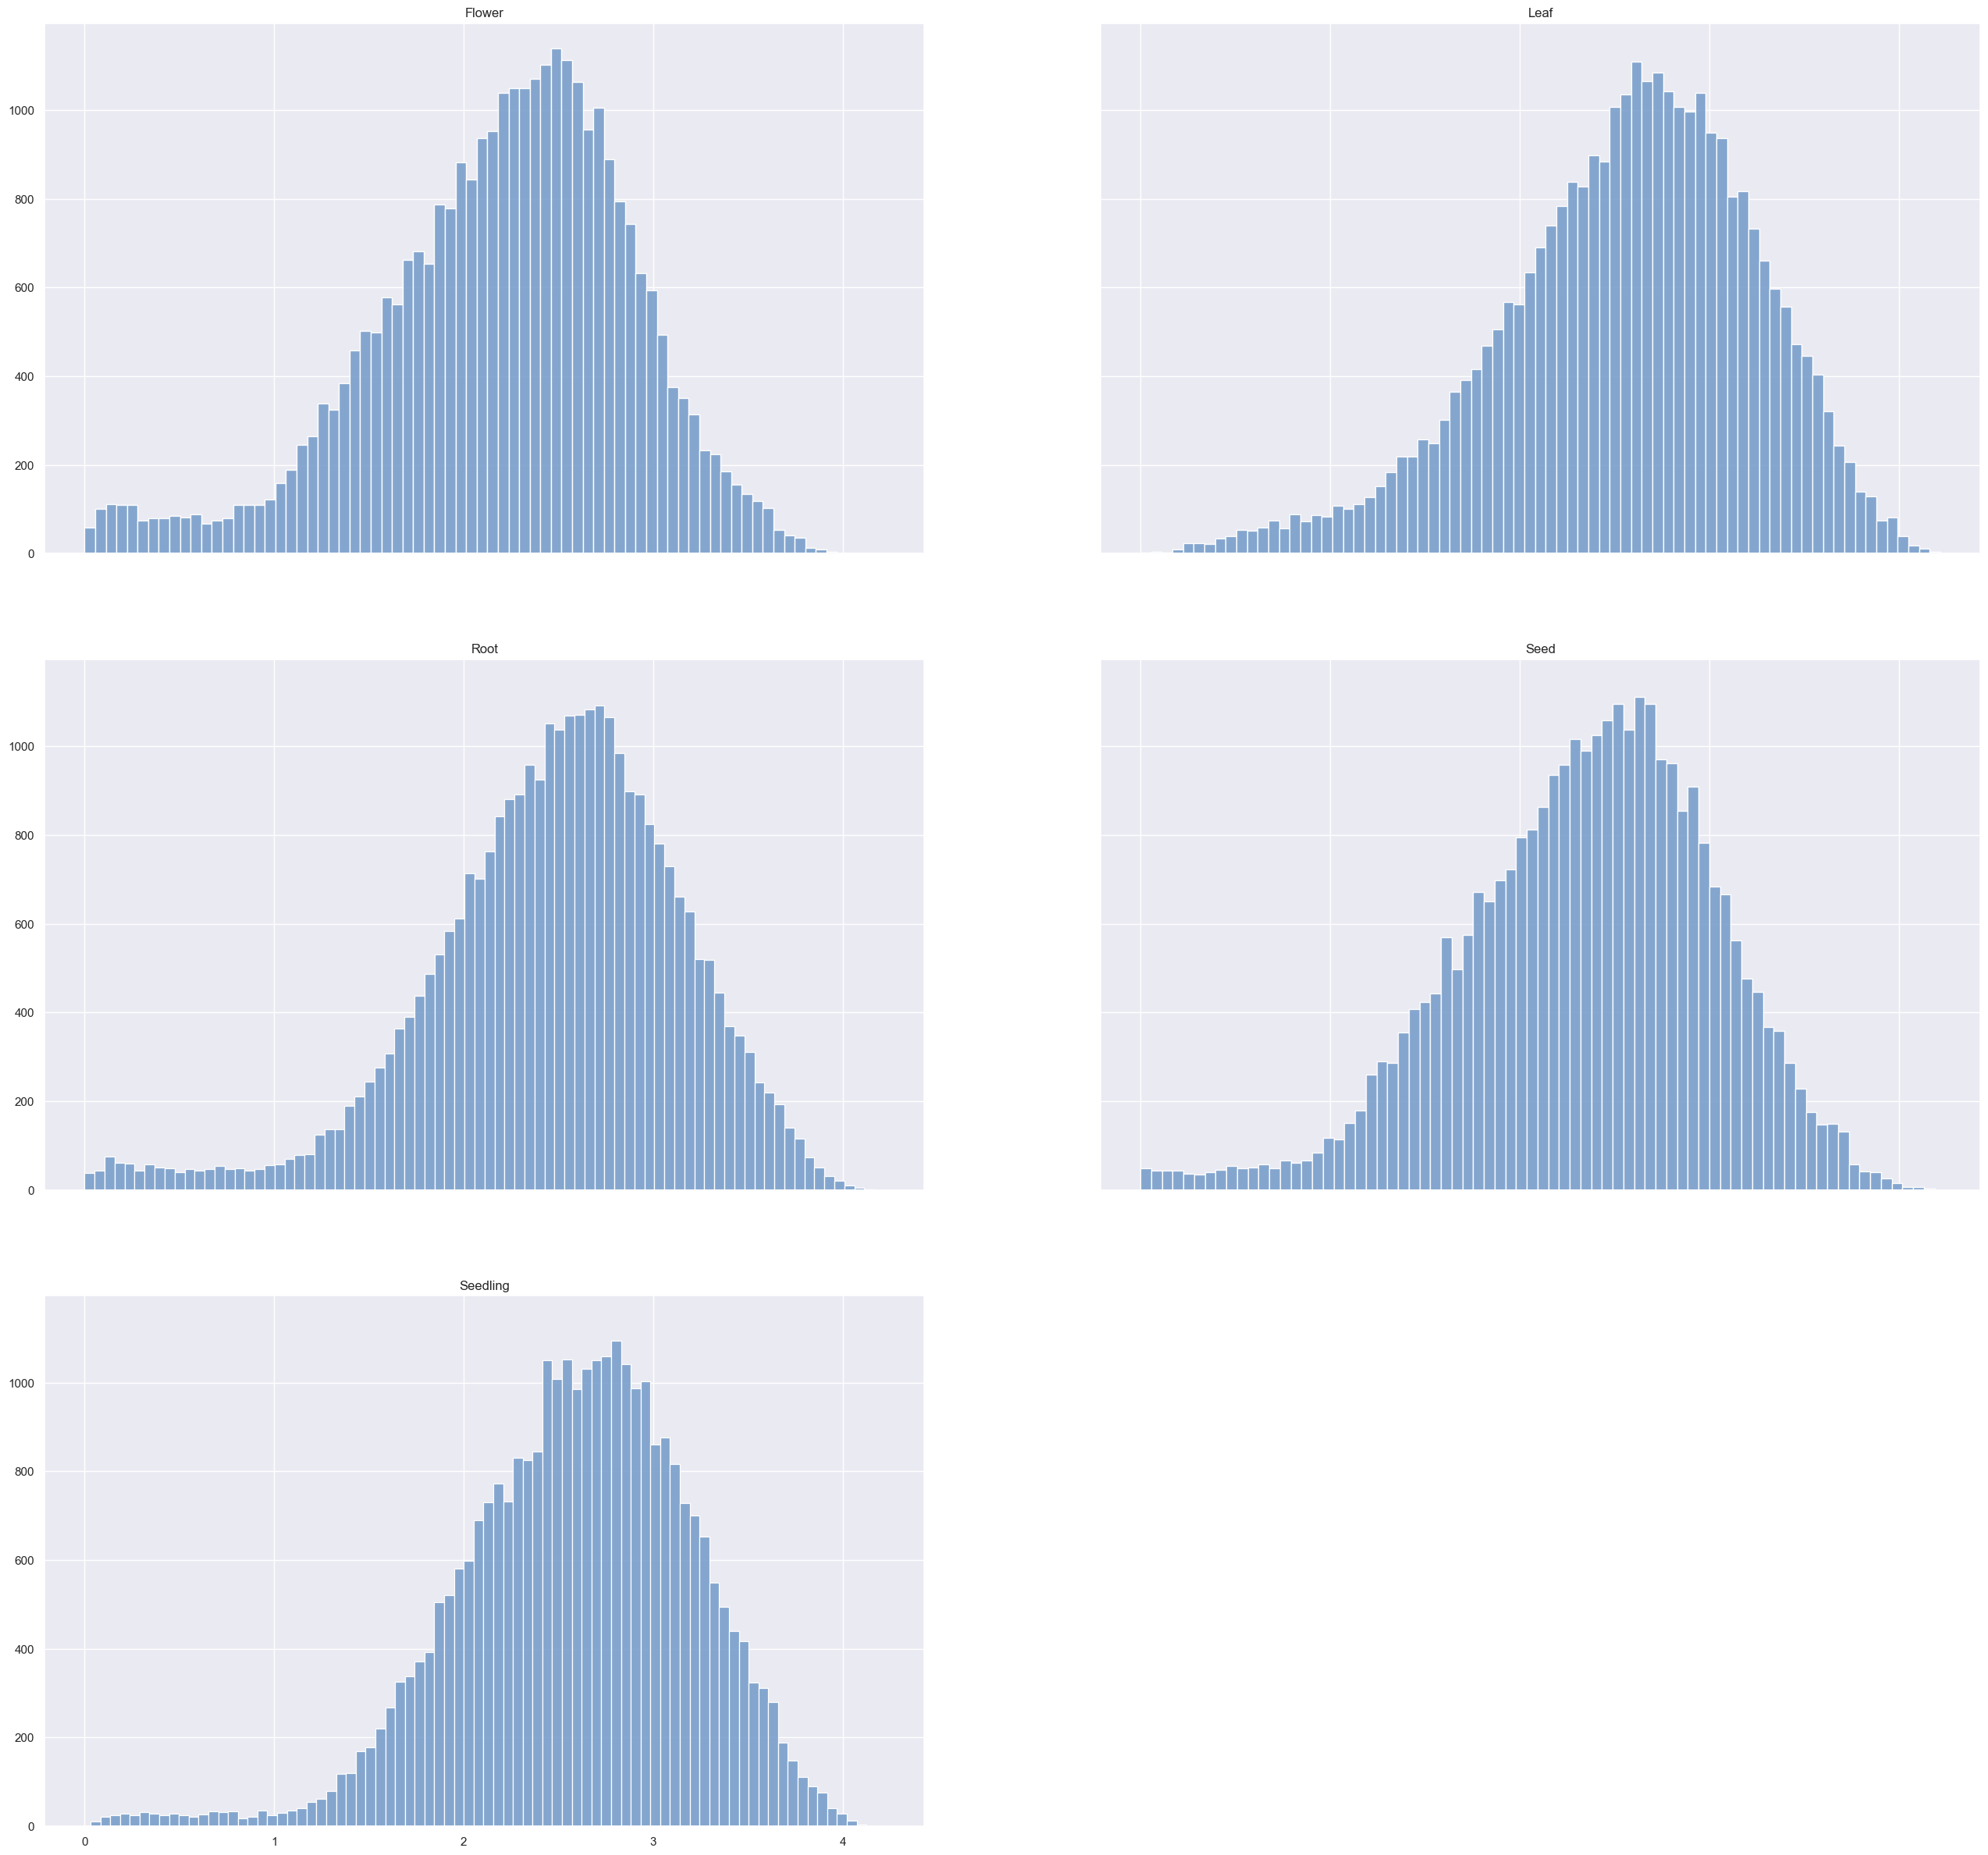

In [10]:
# Compute the regression distribution and display per tissue

distribution = data_target.distribution_group(
	data   = values,
	order  = order,
	select = 'max',
	genes  = anndata.var.index.to_list()
)

data_target.distribution_histplot(
	data     = distribution,
	groupby  = 'tissue',
	discrete = False,
	filename = os.path.join(OUT_PLOT, 'distribution-tissue-p80')
)

## 2.2 Save

In [11]:
# Save the target transcript tpm values

data_writer.write_json(
	data     = values,
	filename = os.path.join(OUT_DATA, 'target-values.json')
)

data_writer.write_json(
	data     = order,
	filename = os.path.join(OUT_DATA, 'target-order.json')
)

# 3. Classification

In [12]:
# Extract the transcript tpm classification per group (reuses tpm values from regression extraction)

labels, bounds = data_target.classify_tpm(
	data    = values,
	classes = 5
)

In [13]:
# Display bounds in different configurations (start, values and mapping are manually set based on nbp02-anndata)

data_target.display_bounds_mapping(
	bounds     = bounds['tissue-mean'],
	start      = 'boxcox1p',
	values = {
		'min_value'  :  0.0,
		'max_value'  :  4.27402122112829000,
		'box_lambda' : -0.22037471317117235,
		'log_base'   :  2
	},
	mapping = {
		'log1p'    : None,
		'boxcox1p' : None,
		'normal'   : 'boxcox1p',
		'standard' : 'boxcox1p'
	}
)

                             boxcox1p |                           tpm
---------------------------------------------------------------------
level-0       0.00000 -       0.67674 |       0.00000 -       1.08102
level-1       0.67674 -       1.17324 |       1.08102 -       2.88630
level-2       1.17324 -       1.70754 |       2.88630 -       7.51799
level-3       1.70754 -       2.21783 |       7.51799 -      19.99703
level-4       2.21783 -       3.97095 |      19.99703 -  12,574.29814


In [14]:
# Display an example of the transcript classification

gene = anndata.var.index.to_list()[0]

for index, (key, value) in enumerate(labels[gene].items()) :
	print(f'{key:17s} : [{len(value):2d}] ' + ' '.join('{:1d}'.format(x) for x in value))

tissue-max        : [ 5] 1 3 3 3 3
tissue-mean       : [ 5] 2 2 4 2 3
age-max           : [ 4] 3 3 0 3
age-mean          : [ 4] 2 3 2 3
group-max         : [14] 2 3 4 1 4 1 4 2 1 1 1 4 3 4
group-mean        : [14] 2 2 3 2 2 2 3 2 2 2 2 3 3 3
perturbation-max  : [ 7] 3 3 2 3 2 2 3
perturbation-mean : [ 7] 3 2 3 2 2 2 2


## 3.1 Distributions

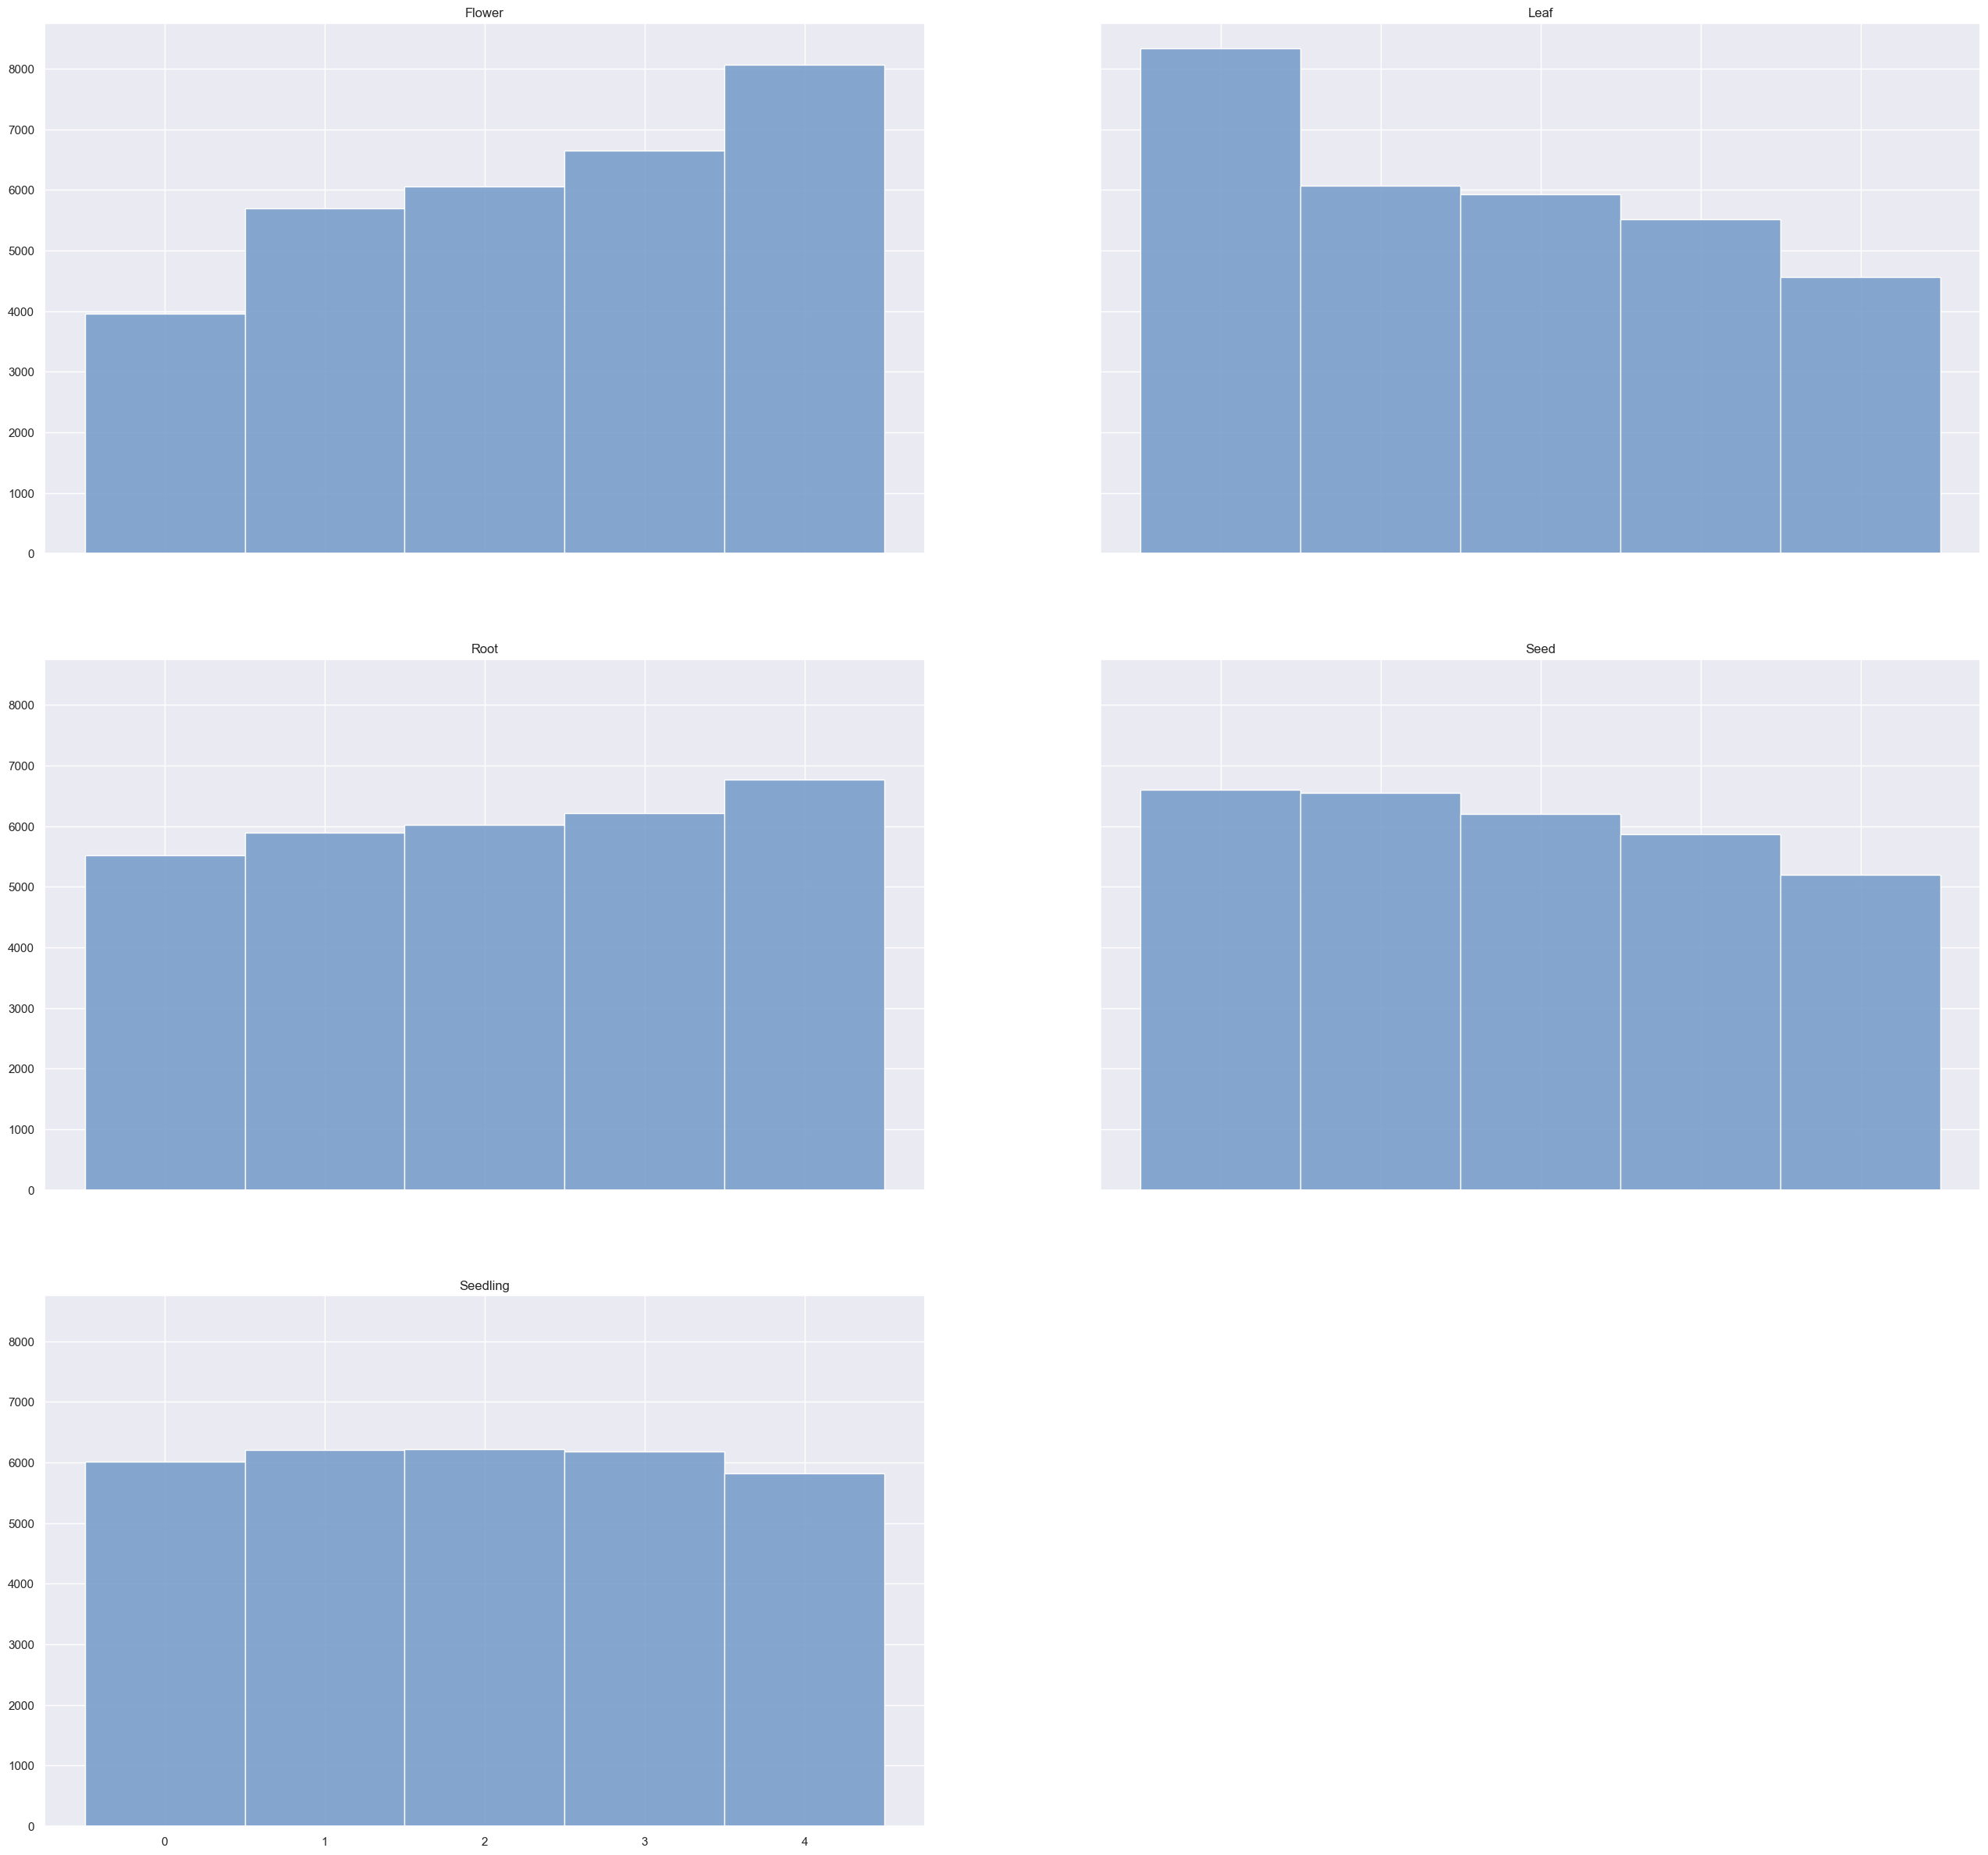

In [15]:
# Compute the classification distribution and display per tissue

distribution = data_target.distribution_group(
	data   = labels,
	order  = order,
	select = 'mean',
	genes  = anndata.var.index.to_list()
)

data_target.distribution_histplot(
	data     = distribution,
	groupby  = 'tissue',
	discrete = True,
	filename = os.path.join(OUT_PLOT, 'distribution-class-tissue-mean')
)

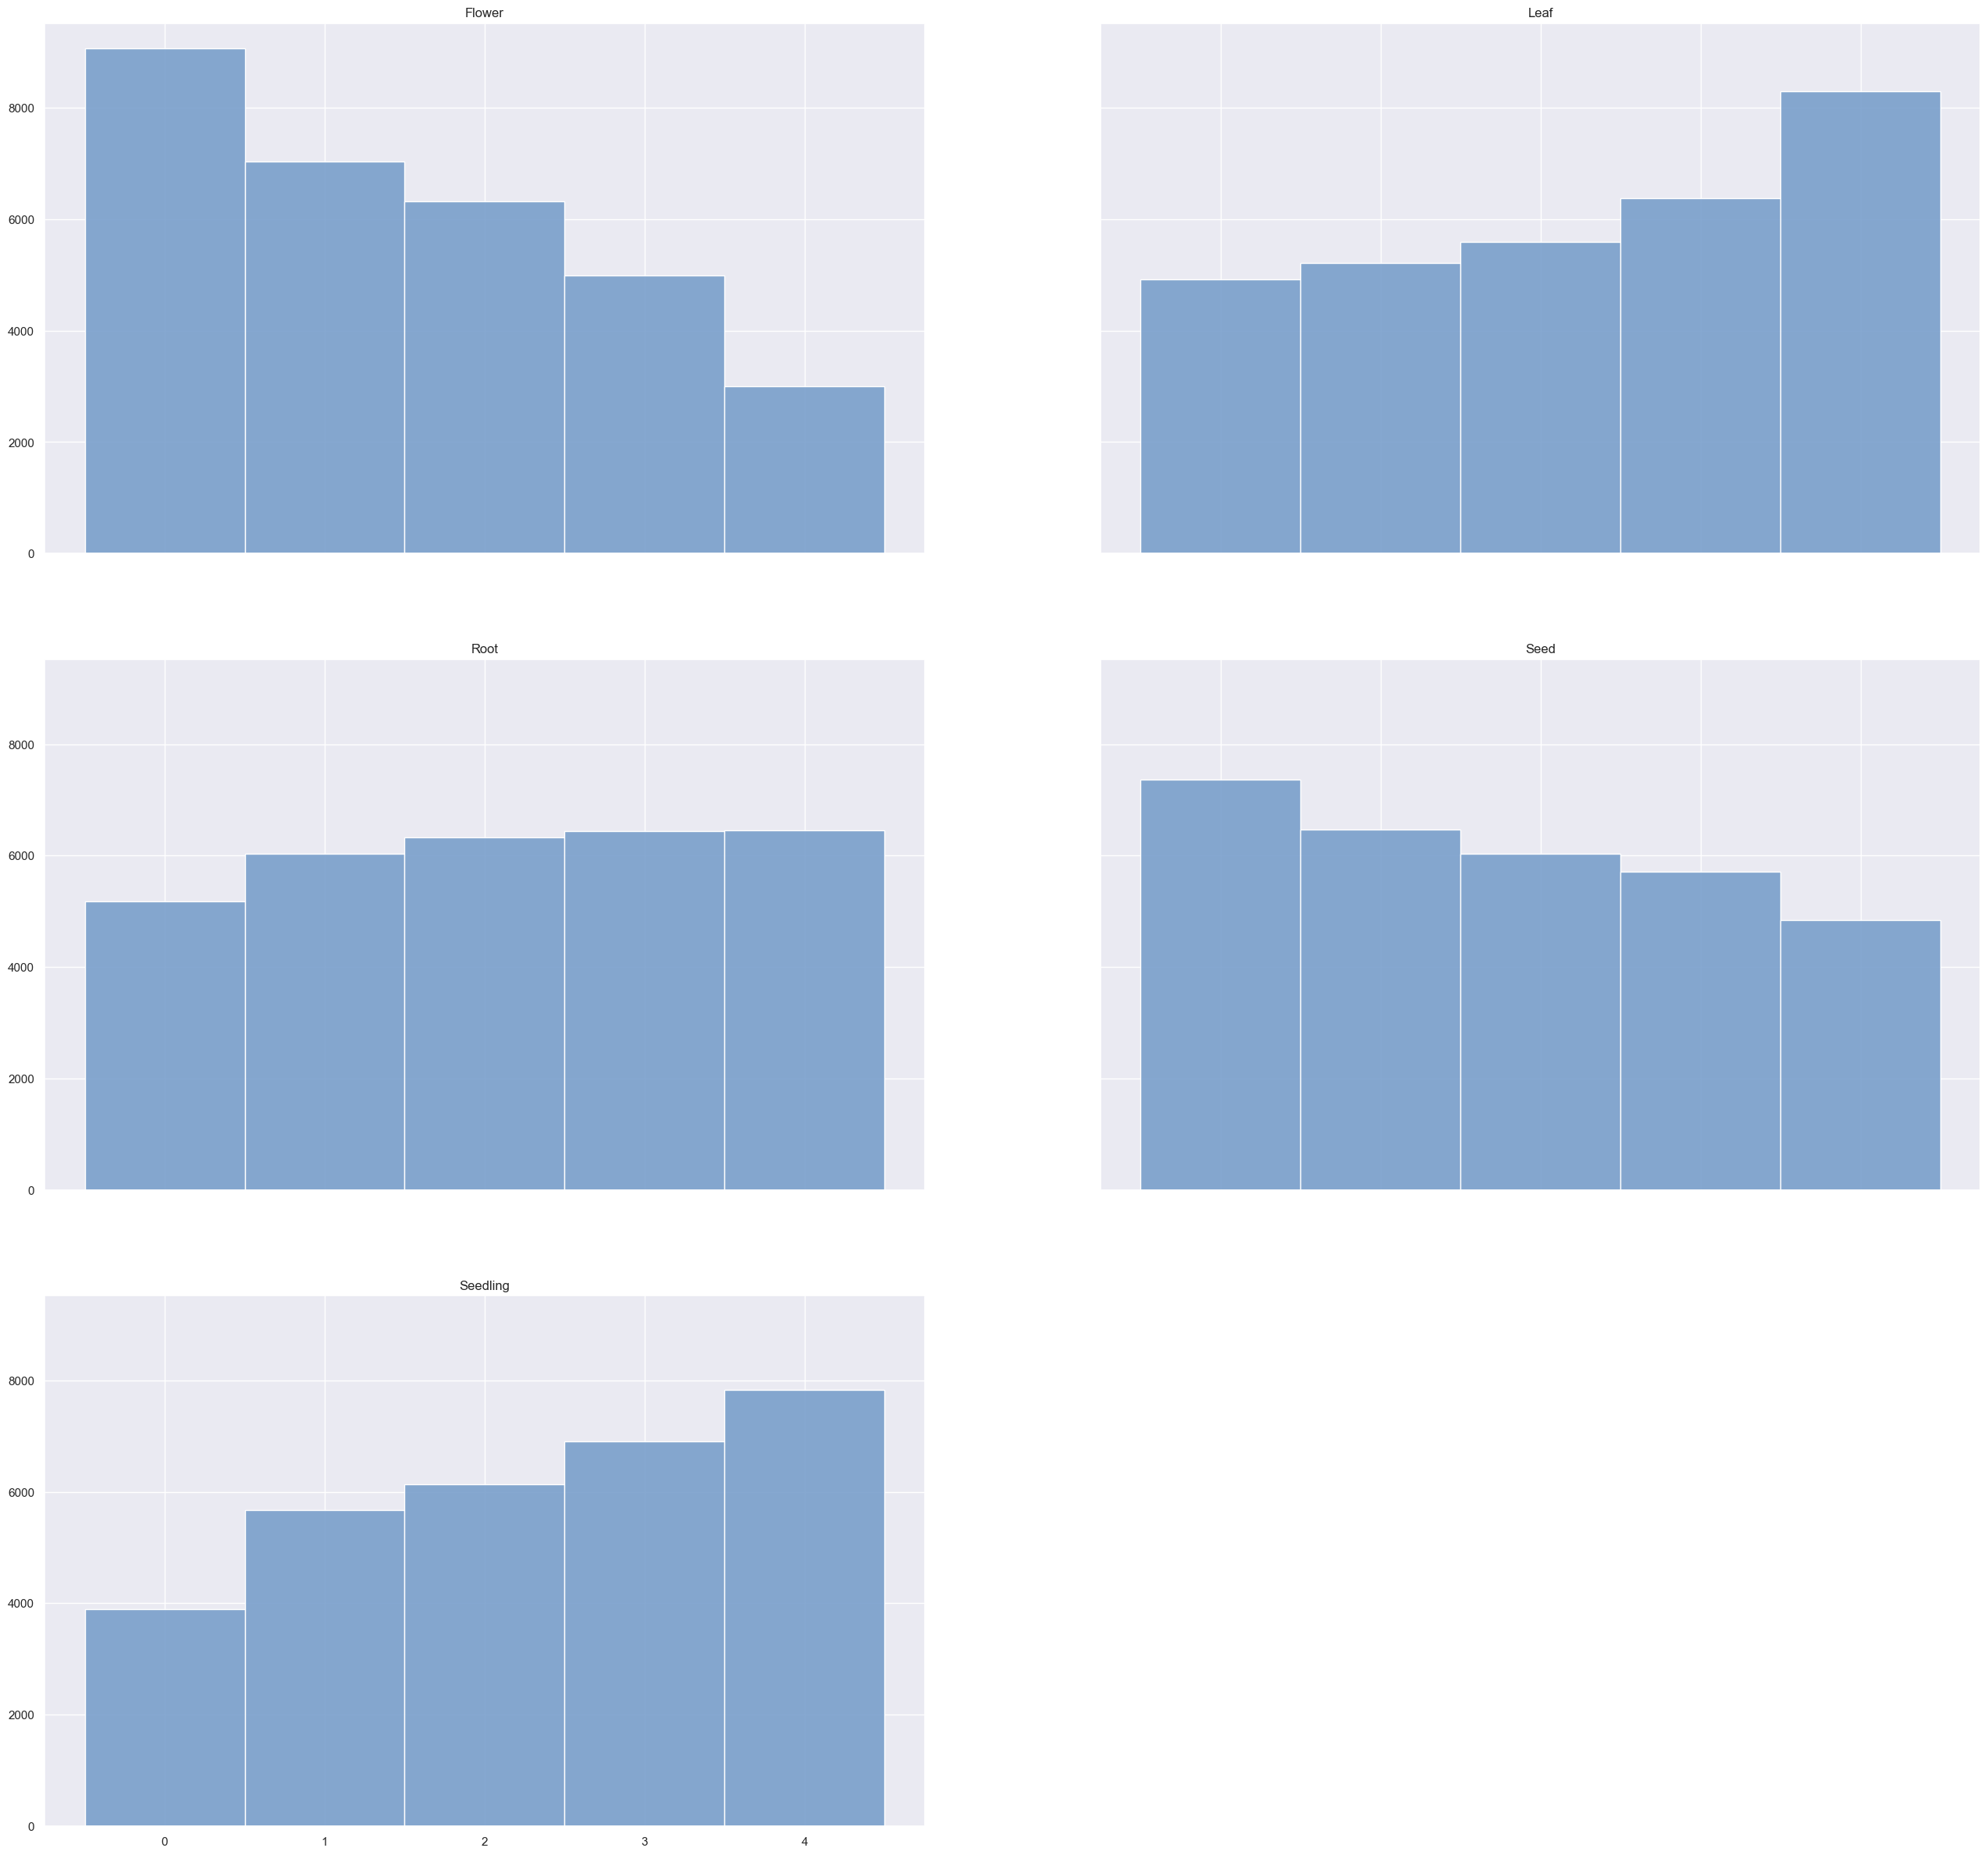

In [16]:
# Compute the classification distribution and display per tissue

distribution = data_target.distribution_group(
	data   = labels,
	order  = order,
	select = 'max',
	genes  = anndata.var.index.to_list()
)

data_target.distribution_histplot(
	data     = distribution,
	groupby  = 'tissue',
	discrete = True,
	filename = os.path.join(OUT_PLOT, 'distribution-class-tissue-p80')
)

## 3.2 Save

In [17]:
# Save the target transcript classification

data_writer.write_json(
	data     = labels,
	filename = os.path.join(OUT_DATA, 'target-labels.json')
)

# 4. Mapping

## 4.1 Average

In [18]:
# Create binarizers and mapping lookup

features_binarizer = dict()
features_encode    = dict()

transcripts = list(values.keys())
functions   = ['mean']
groups      = ['tissue', 'age', 'group', 'perturbation']

for group, function in itertools.product(groups, functions) :
	group_order = order[group]

	dataframe = DataFrame()
	binarizer = LabelBinarizer()
	binarizer = binarizer.fit(group_order)

	key   = f'{group}-{function}'
	group = group.capitalize()

	dataframe['Transcript'] = transcripts
	dataframe['TPM_Value']  = [values[x][key] for x in transcripts]
	dataframe['TPM_Label']  = [labels[x][key] for x in transcripts]
	dataframe[group]        = [group_order    for x in transcripts]

	dataframe = dataframe.explode(['TPM_Value', 'TPM_Label', group])
	dataframe = dataframe.reset_index(drop = True)

	features_binarizer[key] = binarizer
	features_encode[key]    = dataframe

In [19]:
# Save binarizers and mapping lookup

for key in features_binarizer.keys() :
	binarizer = features_binarizer[key]
	dataframe = features_encode[key]

	data_writer.write_csv(
		data        = dataframe,
		filename    = os.path.join(OUT_DATA, f'mapping-{key}.csv'),
		write_index = False
	)

	data_writer.write_pickle(
		data     = binarizer,
		filename = os.path.join(OUT_DATA, f'binarizer-{key}.pkl')
	)

## 4.2 Exact

In [20]:
raise Warning('Hardcoded Execution Stop - Volatile Code :: DataFrame Explode')

Warning: Hardcoded Execution Stop - Volatile Code :: DataFrame Explode

In [ ]:
# Get n samples per transcript

samples = list()
amount  = 2

for _, x in anndata.obs.groupby('Tissue') :
	samples.extend(x.sample(n = amount).index.tolist())

anndata = anndata[samples, :]

In [ ]:
# Create mapping and explode per sample

label_tissue       = anndata.obs['Tissue'].to_numpy()
label_perturbation = anndata.obs['Perturbation'].to_numpy()
label_age          = anndata.obs['Age'].to_numpy()
label_group        = anndata.obs['Group'].to_numpy()

samples     = anndata.obs.index.tolist()
transcripts = anndata.var.index.tolist()

dataframe = DataFrame()

dataframe['Sample']       = samples
dataframe['Trancript']    = [transcripts               for i in range(len(onehot_tissue))]
dataframe['TPM_Value']    = [anndata[i, :]             for i in samples]
dataframe['Tissue']       = [onehot_tissue[i, :]       for i in range(len(onehot_tissue))]
dataframe['Age']          = [onehot_age[i, :]          for i in range(len(onehot_tissue))]
dataframe['Perturbation'] = [onehot_perturbation[i, :] for i in range(len(onehot_tissue))]

dataframe = dataframe.explode(['Trancript', 'TPM_Value'])

In [ ]:
# Combine exact targets and features

targets  = dict()
features = dict()

for _, row in dataframe.iterrows() :
	feature = list()

	feature.extend(list(row['Tissue']))
	feature.extend(list(row['Age']))
	feature.extend(list(row['Perturbation']))
	feature.extend(list(row['Group']))

    sample = row['Sample'] + '?' + row['Trancript']

    targets[sample]  = row['TPM_Value']
    features[sample] = numpy.array(feature, dtype = int)

In [ ]:
# Save exact targets and features

data_writer.write_npz(
	data     = targets,
	filename = os.path.join(OUT_DATA, 'values-exact')
)

data_writer.write_npz(
	data     = features,
	filename = os.path.join(OUT_DATA, 'features-exact')
)